**Breast Cancer Diagnosis Prediction using K-Nearest Neighbors (KNN) and K-Means Clustering** 
##
Classify breast cancer diagnoses into two categories: malignant (M) and benign (B).The project analyzes tumor characteristics from the Wisconsin Diagnostic Breast Cancer dataset.
##

**Objective**
##
Apply both unsupervised (K-Means) and supervised (KNN) learning techniques

Compare clustering vs classification approaches

Achieve high accuracy in cancer diagnosis prediction

Create reproducible and deployable machine learning models
##

**Import Libraries**
##
Libraries that is being used for all the approaches and stages
##

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pickle
import warnings
warnings.filterwarnings('ignore')

**Load and Process Data**
##
-  Dataset those are csv file has been loaded here and processing data by cleaning dataset.
-  Normalize Dataset for scaling between 0 to 1 using MinMax.
#

In [13]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
df = pd.read_csv('../Data/dataset.csv')

df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

df.drop(columns=['id'], inplace=True, errors='ignore')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

X = df.drop(columns=['diagnosis'])
y = df['diagnosis']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
print("Data preprocessing complete.")
print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")
df_preprocessed = X_scaled.copy()
df_preprocessed['diagnosis'] = y.reset_index(drop=True)

preprocess_path = '../Data/preprocess.csv'
df_preprocessed.to_csv(preprocess_path, index=False)
print(f"Saved preprocessed data to {preprocess_path}")

Data preprocessing complete.
Training samples: 455, Test samples: 114
Saved preprocessed data to ../Data/preprocess.csv


**K-Means Clustering** 
##
Unsupervised Learning K-Means groups data points into K clustersby minimizing distance to cluster centroids.
##
##
-  Spliting Data into 80% train, 20% test
-  K-Means Clustering with k=2

Saved test set to ../Data/test.csv (rows=114)
Saved K-Means model to ../Models\Kmeans.pkl

Average diagnosis value per cluster:
Cluster
0    0.952381
1    0.084211
Name: Actual, dtype: float64

Cross-tabulation between Actual Diagnosis and K-Means Clusters (full data):
Cluster    0    1
Actual           
0          9  348
1        180   32

Full data (mapped clusters) - Accuracy: 0.9279  Precision: 0.9524  Recall: 0.8491  F1: 0.8978
              precision    recall  f1-score   support

           0     0.9158    0.9748    0.9444       357
           1     0.9524    0.8491    0.8978       212

    accuracy                         0.9279       569
   macro avg     0.9341    0.9119    0.9211       569
weighted avg     0.9294    0.9279    0.9270       569


Cross-tabulation between Actual Diagnosis and K-Means Clusters (test set):
Cluster   0   1
Actual         
0         1  71
1        34   8

Test set (mapped clusters) - Accuracy: 0.9211  Precision: 0.9714  Recall: 0.8095  F1: 0.8831
  

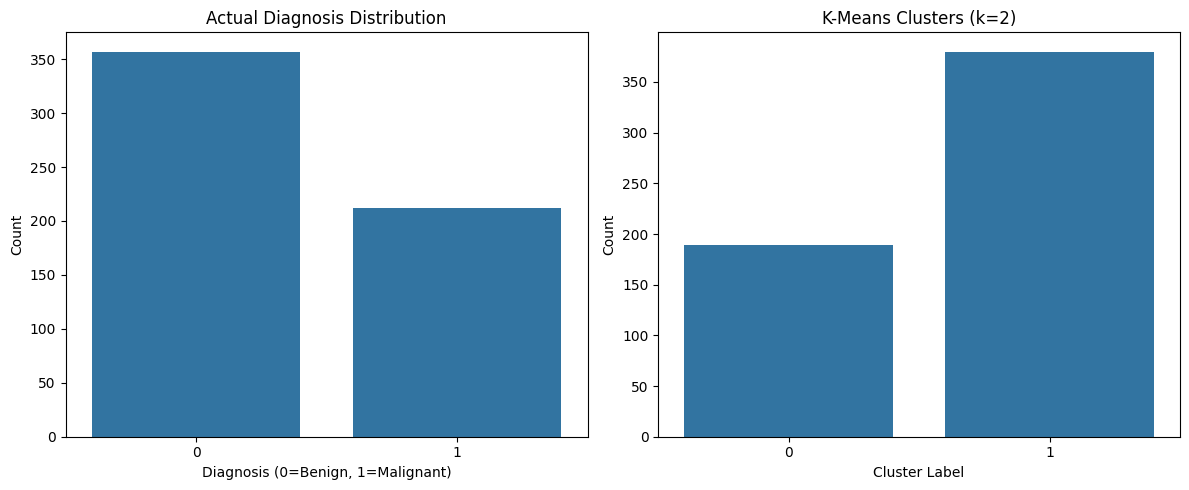

In [16]:
import os
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


df = pd.read_csv('../Data/preprocess.csv')
X = df.drop(columns=['diagnosis'])
y = df['diagnosis']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
test_df = X_test.copy().reset_index(drop=True)
test_df['diagnosis'] = y_test.reset_index(drop=True)
test_path = '../Data/test.csv'
test_df.to_csv(test_path, index=False)
print(f"Saved test set to {test_path} (rows={len(test_df)})")


kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans.fit(X)
cluster_labels = kmeans.labels_


model_dir = '../Models'
os.makedirs(model_dir, exist_ok=True)
kmeans_path = os.path.join(model_dir, 'Kmeans.pkl')
with open(kmeans_path, 'wb') as f:
    pickle.dump(kmeans, f)
print(f"Saved K-Means model to {kmeans_path}")


cluster_df = pd.DataFrame({'Actual': y.values, 'Cluster': cluster_labels})
cluster_means = cluster_df.groupby('Cluster')['Actual'].mean()
print("\nAverage diagnosis value per cluster:")
print(cluster_means)

cluster_to_label = {}
if cluster_means.shape[0] == 2:
    malignant_cluster = int(cluster_means.idxmax())
    benign_cluster = int(cluster_means.idxmin())
    cluster_to_label = {malignant_cluster: 1, benign_cluster: 0}
else:
    for c, m in cluster_means.items():
        cluster_to_label[int(c)] = int(m >= 0.5)


predicted_labels_full = pd.Series(cluster_labels).map(cluster_to_label).fillna(0).astype(int)


test_cluster_labels = kmeans.predict(X_test)
predicted_labels_test = pd.Series(test_cluster_labels).map(cluster_to_label).fillna(0).astype(int)


def compute_and_print_metrics(y_true, y_pred, label):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    print(f"\n{label} - Accuracy: {acc:.4f}  Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}")
    print(classification_report(y_true, y_pred, digits=4))


cross_tab_full = pd.crosstab(cluster_df['Actual'], cluster_df['Cluster'],
                             rownames=['Actual'], colnames=['Cluster'])
print("\nCross-tabulation between Actual Diagnosis and K-Means Clusters (full data):")
print(cross_tab_full)
compute_and_print_metrics(cluster_df['Actual'].values, predicted_labels_full.values, "Full data (mapped clusters)")

cross_tab_test = pd.crosstab(y_test.reset_index(drop=True), pd.Series(test_cluster_labels),
                            rownames=['Actual'], colnames=['Cluster'])
print("\nCross-tabulation between Actual Diagnosis and K-Means Clusters (test set):")
print(cross_tab_test)
compute_and_print_metrics(y_test.reset_index(drop=True).values, predicted_labels_test.values, "Test set (mapped clusters)")


fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(x=y.values, ax=axes[0])
axes[0].set_title('Actual Diagnosis Distribution')
axes[0].set_xlabel('Diagnosis (0=Benign, 1=Malignant)')
axes[0].set_ylabel('Count')

sns.countplot(x=cluster_labels, ax=axes[1])
axes[1].set_title('K-Means Clusters (k=2)')
axes[1].set_xlabel('Cluster Label')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

**K-Nearest Neighbors (KNN)**  
##
Supervised Learning KNN predicts the class of a sample based on the majority label among its K nearest neighbors.
##
##
 Train a KNN classifier with k=5

Saved test set to ../Data/test.csv (rows=114)
KNN Classifier trained with k=5 neighbors

Train metrics:
{'accuracy': 0.978021978021978, 'precision': 0.9761904761904762, 'recall': 0.9647058823529412, 'f1': 0.9704142011834319}
              precision    recall  f1-score   support

           0     0.9791    0.9860    0.9825       285
           1     0.9762    0.9647    0.9704       170

    accuracy                         0.9780       455
   macro avg     0.9776    0.9753    0.9765       455
weighted avg     0.9780    0.9780    0.9780       455


Test metrics:
{'accuracy': 0.9736842105263158, 'precision': 1.0, 'recall': 0.9285714285714286, 'f1': 0.9629629629629629}
              precision    recall  f1-score   support

           0     0.9600    1.0000    0.9796        72
           1     1.0000    0.9286    0.9630        42

    accuracy                         0.9737       114
   macro avg     0.9800    0.9643    0.9713       114
weighted avg     0.9747    0.9737    0.9735       114


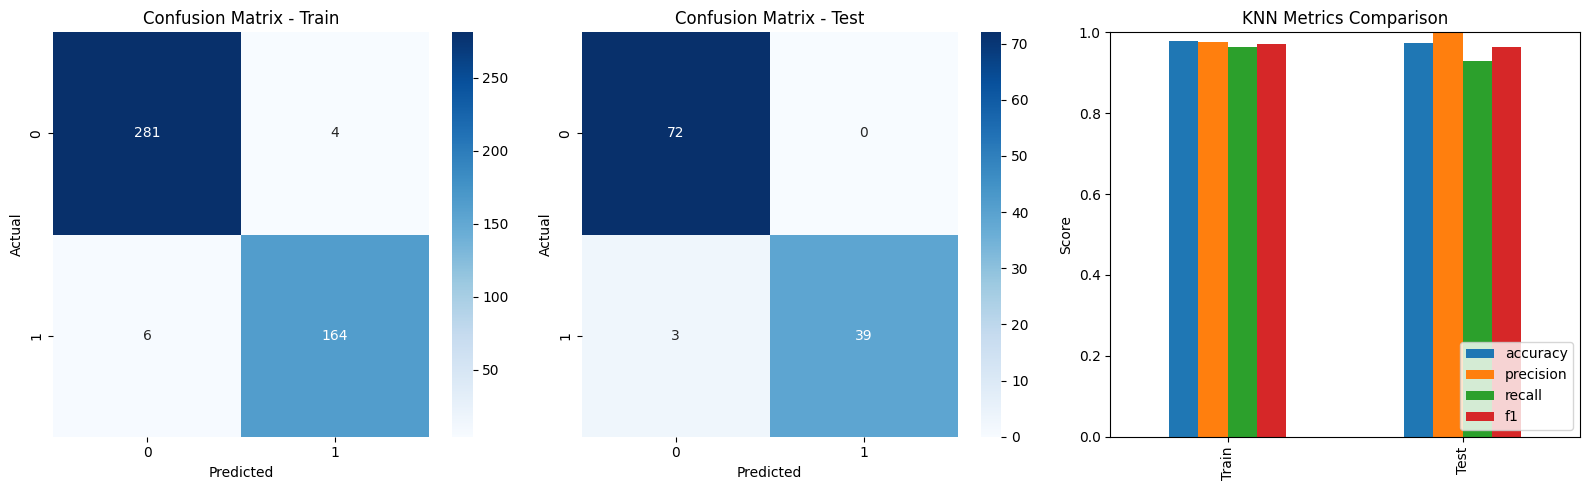

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, confusion_matrix)
import pickle

preprocess_path = '../Data/preprocess.csv'
test_path = '../Data/test.csv'


df = pd.read_csv(preprocess_path)
X = df.drop(columns=['diagnosis'])
y = df['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=48, stratify=y
)


test_df = X_test.copy().reset_index(drop=True)
test_df['diagnosis'] = y_test.reset_index(drop=True)
test_df.to_csv(test_path, index=False)
print(f"Saved test set to {test_path} (rows={len(test_df)})")


knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
print("KNN Classifier trained with k=5 neighbors")


y_pred_train = knn.predict(X_train)
y_pred_test = knn.predict(X_test)


def metrics_dict(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0)
    }

train_metrics = metrics_dict(y_train, y_pred_train)
test_metrics = metrics_dict(y_test, y_pred_test)


print("\nTrain metrics:")
print(train_metrics)
print(classification_report(y_train, y_pred_train, digits=4))
print("\nTest metrics:")
print(test_metrics)
print(classification_report(y_test, y_pred_test, digits=4))


model_path = '../Models/knn_model.pkl'
os.makedirs(os.path.dirname(model_path), exist_ok=True)
with open(model_path, 'wb') as f:
    pickle.dump(knn, f)
print(f"Saved trained KNN model to {model_path}")


cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - Train')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix - Test')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')


metrics_df = pd.DataFrame({
    'Train': train_metrics,
    'Test': test_metrics
}).T[['accuracy', 'precision', 'recall', 'f1']]

metrics_df.plot(kind='bar', ax=axes[2], ylim=(0,1))
axes[2].set_title('KNN Metrics Comparison')
axes[2].set_ylabel('Score')
axes[2].legend(loc='lower right')

plt.tight_layout()

results_fig = '../Models/knn_results.png'
plt.savefig(results_fig, dpi=150)
print(f"Saved metrics/CM figure to {results_fig}")
plt.show()

**Visulization**
## 
Web interface for interactions of a user

In [1]:
from flask import Flask, request, render_template_string
import pandas as pd
import os
import pickle
import numpy as np

PRE = '../Data/preprocess.csv'
MD = '../Models'
KNN = os.path.join(MD, 'knn_model.pkl')
KM = os.path.join(MD, 'Kmeans.pkl')

app = Flask(__name__)

def load_models():
    kn = None
    km = None
    try:
        with open(KNN, 'rb') as f:
            kn = pickle.load(f)
    except Exception:
        kn = None
    try:
        with open(KM, 'rb') as f:
            km = pickle.load(f)
    except Exception:
        km = None
    return kn, km

def km_map(km, X, y):
    
    c = km.predict(X)
    m = pd.DataFrame({'c': c, 'y': y.values}).groupby('c')['y'].mean()
    return {int(ci): int(v >= 0.5) for ci, v in m.items()}

@app.route('/', methods=['GET', 'POST'])
def index():
    if not os.path.exists(PRE):
        return "<h3>preprocess.csv not found</h3>"

    df = pd.read_csv(PRE)
    feats = [c for c in df.columns if c != 'diagnosis']
    
    if len(feats) >= 3:
        form_feats = feats[:3]
    elif len(feats) == 2:
        form_feats = feats[:2]
    else:
        form_feats = feats

    kn, km = load_models()
    result_text = None
    err = None

    if request.method == 'POST':
        try:
            vals = []
            for f in form_feats:
                v = request.form.get(f)
                if v is None or v == '':
                    vals.append(0.0)
                else:
                    vals.append(float(v))
            
            row = pd.DataFrame(np.zeros((1, len(feats))), columns=feats)
            for i, f in enumerate(form_feats):
                row.at[0, f] = vals[i]

            primary = None

            if kn is not None:
                try:
                    primary = int(kn.predict(row)[0])
                except Exception as e:
                    err = f"Classifier error: {e}"
            elif km is not None:
                try:
                    mapping = km_map(km, df[feats], df['diagnosis'])
                    cluster_id = int(km.predict(row)[0])
                    primary = mapping.get(cluster_id, None)
                except Exception as e:
                    err = f"Clustering error: {e}"
            else:
                err = "No trained models available."

            if err is None:
                if primary is None:
                    result_text = "Model cannot determine prediction for provided inputs."
                else:
                    result_text = "Breast Cancer: Yes" if int(primary) == 1 else "Breast Cancer: No"
        except Exception as e:
            err = str(e)

    t = """<!doctype html><html><head><meta charset="utf-8"><title>BreastCare</title>
<link href="https://fonts.googleapis.com/css2?family=Inter:wght@300;400;600;700&display=swap" rel="stylesheet">
<style>body{font-family:Inter,Arial;background:linear-gradient(135deg,#f0f4ff,#eefbf7);margin:0;padding:36px}
.wrap{max-width:820px;margin:0 auto}.card{background:linear-gradient(180deg,rgba(255,255,255,0.9),#ffffff);padding:24px;border-radius:14px;box-shadow:0 12px 40px rgba(8,15,52,0.08)}
h1{margin:0 0 6px;font-size:22px;color:#0f172a} p.lead{margin:0 0 18px;color:#475569}
.grid{display:grid;grid-template-columns:repeat(3,1fr);gap:12px}
label{font-size:13px;color:#0f172a;display:block;margin-bottom:6px}
input{width:100%;padding:10px;border-radius:10px;border:1px solid #e6eef9;background:#fbfdff}
button{margin-top:14px;padding:12px 16px;background:#0ea5a4;color:#fff;border:0;border-radius:10px;font-weight:600;cursor:pointer}
.result{margin-top:16px;padding:14px;border-radius:10px;text-align:center;font-weight:700}
.yes{background:#fee2e2;color:#991b1b}
.no{background:#ecfdf5;color:#065f46}
.note{color:#64748b;margin-top:12px;font-size:13px}
</style></head><body><div class="wrap"><div class="card">
<h1>BreastCare — Quick Check</h1><p class="lead">Enter values for the fields and press Predict</p>
<form method="post"><div class="grid">{% for f in form_feats %}<div><label>{{f}}</label><input name="{{f}}" step="any" required></div>{% endfor %}</div><button type="submit">Predict</button></form>
{% if result_text %}
<div class="result {% if 'Yes' in result_text %}yes{% elif 'No' in result_text %}no{% endif %}">{{result_text}}</div>
{% endif %}
{% if err %}<div style="color:#dc2626;margin-top:12px">{{err}}</div>{% endif %}
<p class="note">This tool uses trained models saved in the project. If no model is available the form still accepts inputs but cannot predict.</p>
</div></div></body></html>"""

    return render_template_string(t, form_feats=form_feats, result_text=result_text, err=err)

if __name__ == '__main__':
    app.run(host='127.0.0.1', port=5001, debug=True, use_reloader=False)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5001
Press CTRL+C to quit
127.0.0.1 - - [06/Dec/2025 10:12:35] "GET / HTTP/1.1" 200 -
